# `init_state -> actions -> final_state`

Gather a dataset of triplets `(initial state, actions, final state)` for each pair of initial and final states

In [1]:
from pathlib import Path

import pandas as pd

DATA_DIRECTORY = Path("./data/")  # change as necessary

## 1. Load tactics with states before and after

In [6]:
goals = pd.read_parquet(DATA_DIRECTORY / "goals_before_after.parquet").drop_duplicates()

## 2. Group tactics by `parent_key`

### 3. Build triplets

1. Groupby tactics by `parent_key`.
2. In each group do the following:  
    2.1. Sort by `tactic_instance` (considering it as a vector of ints).  
    2.2. For each consequitive elements with `goal_before[i] == goal_after[i - 1]` construct all triplets.

In [8]:
def _triplets(gg):
    triplets = []
    for i in range(len(gg)):
        for j in range(i + 1, len(gg)):
            tactic = ', '.join(gg.human_tactic_code.values[i:j + 1])
            triplets.append((
                gg.goal_before.values[i],
                tactic,
                gg.goal_after.values[j],
                gg.decl_name.values[i]
            ))
    triplets = pd.DataFrame(triplets, columns=['goal_before', 'tactic', 'goal_after', 'decl_name'])
    return triplets


def get_triplets(group):
    # 1. sort by tactic_instance
    for i in range(4):
        group[f'tac_inst_{i}'] = group.tactic_instance.apply(lambda x: int(x.split(':')[i]))
    group = group.sort_values([f"tac_inst_{i}" for i in range(4)])
    triplets = [group[['goal_before', 'human_tactic_code', 'goal_after', 'decl_name']]
                .rename(columns={'human_tactic_code': 'tactic'})]
    i = 0
    while i < len(group):
        j = i + 1
        while j < len(group) and group.goal_after.iloc[j - 1] == group.goal_before.iloc[j]:
            j += 1
        triplets.append(_triplets(group.iloc[i:j]))  
        i = j  
        
    return pd.concat(triplets, ignore_index=True)

In [9]:
import tqdm
from joblib import Parallel, delayed


triplets = Parallel(-1)(
    delayed(get_triplets)(group) for _, group in tqdm.tqdm(goals.groupby('parent_key'))
)

100%|██████████| 98627/98627 [02:53<00:00, 567.68it/s]


In [10]:
triplets = pd.concat(triplets, ignore_index=True)
triplets.shape

(613721, 4)

In [16]:
triplets.to_parquet(DATA_DIRECTORY / 'triplets.parquet', engine='pyarrow', index=False)

In [17]:
proof_length = []
for name, group in goals.groupby('parent_key'):
    if group.parent_type.iloc[0] == 'proof':
        proof_length.append(len(group))
        if proof_length[-1] == 10:
            break

In [18]:
tr = []
for _, gg in goals[goals.decl_name == 'int.neg_succ_of_nat_mul_sub_nat_nat'].copy().groupby('parent_key'):
    tr.append(get_triplets(gg))

tr = pd.concat(tr)
tr

,goal_before,tactic,goal_after,decl_name
0,m n k : ℕ\n⊢ -[1+ m] * int.sub_nat_nat n k = i...,have h := nat.lt_or_ge n k,"m n k : ℕ,\nh : n < k ∨ k ≤ n\n⊢ -[1+ m] * int...",int.neg_succ_of_nat_mul_sub_nat_nat
1,"m n k : ℕ,\nh : n < k ∨ k ≤ n\n⊢ -[1+ m] * int...",cases h with h h,"case or.inl\nm n k : ℕ,\nh : n < k\n⊢ -[1+ m] ...",int.neg_succ_of_nat_mul_sub_nat_nat
2,"case or.inl\nm n k : ℕ,\nh : n < k\n⊢ -[1+ m] ...","{ have h' : succ m * n < succ m * k, exact nat...","case or.inr\nm n k : ℕ,\nh : k ≤ n\n⊢ -[1+ m] ...",int.neg_succ_of_nat_mul_sub_nat_nat
3,"case or.inr\nm n k : ℕ,\nh : k ≤ n\n⊢ -[1+ m] ...",have h' : n > k ∨ k = n,"m n k : ℕ,\nh : k ≤ n\n⊢ n > k ∨ k = n\n\nm n ...",int.neg_succ_of_nat_mul_sub_nat_nat
4,"m n k : ℕ,\nh : k ≤ n\n⊢ n > k ∨ k = n\n\nm n ...",exact decidable.lt_or_eq_of_le h,"m n k : ℕ,\nh : k ≤ n,\nh' : n > k ∨ k = n\n⊢ ...",int.neg_succ_of_nat_mul_sub_nat_nat
...,...,...,...,...
16,"m n k : ℕ,\nh : k ≤ n,\nh' : n > k,\nh₁ : m.su...","rw [sub_nat_nat_of_le h, sub_nat_nat_of_lt h₁]...","m n k : ℕ,\nh : k ≤ n,\nh' : n > k,\nh₁ : m.su...",int.neg_succ_of_nat_mul_sub_nat_nat
17,"m n k : ℕ,\nh : k ≤ n,\nh' : n > k,\nh₁ : m.su...","rw [sub_nat_nat_of_le h, sub_nat_nat_of_lt h₁]...",,int.neg_succ_of_nat_mul_sub_nat_nat
18,"m n k : ℕ,\nh : k ≤ n,\nh' : n > k,\nh₁ : m.su...","simp [nat.mul_sub_left_distrib, nat.mul_comm],...","m n k : ℕ,\nh : k ≤ n,\nh' : n > k,\nh₁ : m.su...",int.neg_succ_of_nat_mul_sub_nat_nat
19,"m n k : ℕ,\nh : k ≤ n,\nh' : n > k,\nh₁ : m.su...","simp [nat.mul_sub_left_distrib, nat.mul_comm],...",,int.neg_succ_of_nat_mul_sub_nat_nat


In [19]:
df = triplets[triplets.decl_name == 'int.neg_succ_of_nat_mul_sub_nat_nat']
df

,goal_before,tactic,goal_after,decl_name
1628,m n k : ℕ\n⊢ -[1+ m] * int.sub_nat_nat n k = i...,have h := nat.lt_or_ge n k,"m n k : ℕ,\nh : n < k ∨ k ≤ n\n⊢ -[1+ m] * int...",int.neg_succ_of_nat_mul_sub_nat_nat
1629,"m n k : ℕ,\nh : n < k ∨ k ≤ n\n⊢ -[1+ m] * int...",cases h with h h,"case or.inl\nm n k : ℕ,\nh : n < k\n⊢ -[1+ m] ...",int.neg_succ_of_nat_mul_sub_nat_nat
1630,"case or.inl\nm n k : ℕ,\nh : n < k\n⊢ -[1+ m] ...","{ have h' : succ m * n < succ m * k, exact nat...","case or.inr\nm n k : ℕ,\nh : k ≤ n\n⊢ -[1+ m] ...",int.neg_succ_of_nat_mul_sub_nat_nat
1631,"case or.inr\nm n k : ℕ,\nh : k ≤ n\n⊢ -[1+ m] ...",have h' : n > k ∨ k = n,"m n k : ℕ,\nh : k ≤ n\n⊢ n > k ∨ k = n\n\nm n ...",int.neg_succ_of_nat_mul_sub_nat_nat
1632,"m n k : ℕ,\nh : k ≤ n\n⊢ n > k ∨ k = n\n\nm n ...",exact decidable.lt_or_eq_of_le h,"m n k : ℕ,\nh : k ≤ n,\nh' : n > k ∨ k = n\n⊢ ...",int.neg_succ_of_nat_mul_sub_nat_nat
...,...,...,...,...
1709,"m n k : ℕ,\nh : k ≤ n,\nh' : n > k,\nh₁ : m.su...","rw [sub_nat_nat_of_le h, sub_nat_nat_of_lt h₁]...","m n k : ℕ,\nh : k ≤ n,\nh' : n > k,\nh₁ : m.su...",int.neg_succ_of_nat_mul_sub_nat_nat
1710,"m n k : ℕ,\nh : k ≤ n,\nh' : n > k,\nh₁ : m.su...","rw [sub_nat_nat_of_le h, sub_nat_nat_of_lt h₁]...",,int.neg_succ_of_nat_mul_sub_nat_nat
1711,"m n k : ℕ,\nh : k ≤ n,\nh' : n > k,\nh₁ : m.su...","simp [nat.mul_sub_left_distrib, nat.mul_comm],...","m n k : ℕ,\nh : k ≤ n,\nh' : n > k,\nh₁ : m.su...",int.neg_succ_of_nat_mul_sub_nat_nat
1712,"m n k : ℕ,\nh : k ≤ n,\nh' : n > k,\nh₁ : m.su...","simp [nat.mul_sub_left_distrib, nat.mul_comm],...",,int.neg_succ_of_nat_mul_sub_nat_nat


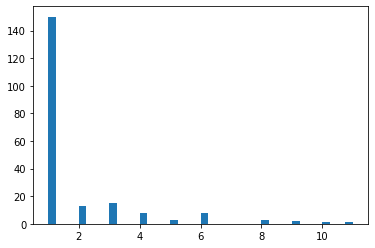

In [20]:
from matplotlib import pyplot as plt

plt.hist(proof_length, bins=40);

In [21]:
proof_length = pd.DataFrame(proof_length)
proof_length.describe()

,0
count,204.000000
mean,1.857843
std,1.855464
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,11.000000
